# TORCphysics Example 3.: Gene Circuit Custom Models and Parameterization

## Overview
This notebook revisits the system composed of two genes from Example 1, but we demonstrate how to modify model parameterization and define new models for custom binding, effect and unbinding of enzymes. We then analyse each system with analysis procedures shown in Example_2, by running multiple simulations and calculating averages and stds.


## Gene Circuit Structure
We have a system composed by two genes in a tandem orientation in the form of:
X________-------left------>________------right------>________X

where X's indicate the surrounding barriers and -----> a gene pointing to the right.
We refer to the genes as 'left' and 'right'.

## Scenarios

### 3.1. Realistic Model (Accelerated): Multi-Stage Supercoiling-Dependent Transcription with Continuous Topoisomerase activity, and one enzyme is added to the environment that binds at the middle of genes, respond and relaxes supercoils.
- Binding, effect and unbinding models are created for the new custom enzyme.
- A new enzyme is added to the environment with this behaviour along with its corresponding binding site.



In [1]:
# Load modules
# ------------------------------------------------------------------------------------------------------------------------
from TORCphysics import Circuit, Site, Environment, utils
from TORCphysics import binding_model as bm
from TORCphysics import effect_model as em
from TORCphysics import unbinding_model as ubm
from TORCphysics import analysis as an
from TORCphysics import visualization as vs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# BINDING MODEL

To define binding models, we need to use the binding module (bm).

Our new enzyme will bind with a given rate if the superhelical density is above a certain threshold. This means that binding can occur if superhelical <= binding_threshold (with binding_threshold=-0.04 as default).

In [2]:
# Let's understand how binding model works
help(bm.BindingModel)

Help on class BindingModel in module TORCphysics.src.binding_model:

class BindingModel(abc.ABC)
 |  BindingModel(filename=None, interacts=False, **oparams)
 |
 |  The BindingModel abstract class used for defining binding models (subclasses).
 |  If you need a new model, define it below.
 |  See how some of the models are defined from this class, so you can make your own and implement it.
 |
 |  Attributes
 |  ----------
 |  filename : str, optional
 |      Path to the site csv file that parametrises the binding model.
 |  interacts : bool, optional
 |     Parameter that indicates if the site/environmental interacts with other bound enzymes. It could be the case
 |     that the bound enzymem may increase the rate of the binding environmental.
 |  oparams : dict, optional
 |      A dictionary containing the parameters used for the binding model.
 |
 |  Method resolution order:
 |      BindingModel
 |      abc.ABC
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self,

In [3]:
# Let's define our new enzyme's binding model: CustomEnzymeBinding
class CustomEnzymeBinding(bm.BindingModel):

    # oparams is a dictionary with parameterisation that you can pass to the model
    def __init__(self, filename=None, **oparams):

        super().__init__(filename, **oparams)  # Call the base class constructor

        if not oparams:
            if filename is None:  # If no params are being given
                self.k_on = 0.03  # Rate at which enzyme binds
                self.binding_threshold = -0.04  # Threshold at which the enzyme will bind
            else: # If a file with parameterisation is being given.
                mydata = pd.read_csv(filename)
                if 'k_on' in mydata.columns:
                    self.k_on = mydata['k_on'][0]
                else:
                    raise ValueError('Error, k_on parameter missing in csv file for CustomEnzymeBinding')
                if 'binding_threshold' in mydata.columns:
                    self.binding_threshold = mydata['binding_threshold'][0]
                else:
                    raise ValueError('Error, binding_threshold parameter missing in csv file for CustomEnzymeBinding')
        else:  # If parametersation is being given.
            self.k_on = oparams['k_on']
            self.binding_threshold = oparams['binding_threshold']

        self.oparams = {'k_on': self.k_on, 'binding_threshold': self.binding_threshold}  # Just in case

    # This function calculates the binding probability
    def binding_probability(self, environmental, superhelical, dt):
        # utils is a module that contains useful functions!
        # utils.Poisson_process returns the probability according rate = k_on * concentration
        # and time step dt.
        if superhelical <= self.binding_threshold:
            return utils.Poisson_process(self.k_on * environmental.concentration, dt)
        else:
            return 0.0

    # Lastly, we need this function that tells the model how the rate is modulated as function of supercoiling.
    def rate_modulation(self, superhelical) -> float:
        if superhelical <= self.binding_threshold:
            return self.k_on
        else:
            return 0.0



# EFFECT MODEL

We do something similar but now with the effect model. For this, we use the effect model module em and Effect class: em.EffectModel

The custom enzyme will introduce positive supercoils at a certain rate k_cat on both sides (left and right).


In [4]:
# Let's understand how effect model works
help(em.EffectModel)

Help on class EffectModel in module TORCphysics.src.effect_model:

class EffectModel(abc.ABC)
 |  EffectModel(filename=None, continuum=False, **oparams)
 |
 |  The EffectModel abstract class used for defining effect models (subclasses).
 |  If you need a new model, define it below.
 |  See how some of the models are defined from this class, so you can make your own and implement it.
 |
 |  Attributes
 |  ----------
 |  filename : str, optional
 |      Path to the site csv file that parametrises the effect model.
 |  oparams : dict, optional
 |      A dictionary containing the parameters used for the effect model.
 |
 |  Method resolution order:
 |      EffectModel
 |      abc.ABC
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, filename=None, continuum=False, **oparams)
 |      The constructor of EffectModel.
 |
 |      Parameters
 |      ----------
 |      filename : str, optional
 |          Path to the site csv file that parametrises the effect model.
 |   

In [5]:
# We need to initialize the class, then define the calculate_effect() function!
# Let's define our new enzyme's effect model
class CustomEnzymeEffect(em.EffectModel):

    def __init__(self, filename=None, **oparams):

        super().__init__(filename, **oparams)  # Call the base class constructor

        if not oparams:
            if filename is None:
                self.k_cat = 0.001  # Rate at which supercoils are added (supercoils/second)
            else:
                mydata = pd.read_csv(filename)
                if 'k_cat' in mydata.columns:
                    self.k_cat = mydata['k_cat'][0]
                else:
                    raise ValueError('Error, k_cat parameter missing in csv file for CustomEnzymeEffect')
        else:
            self.k_cat = oparams['k_cat']

        self.oparams = {'k_cat': self.k_cat}  # Just in case

    # This function calculates the local effect.
    # The model workflow always passes 4 inputs: index = current enzyme index in z_list, current enzyme z, list of enzymes z_list,
    # and time-step dt.
    # Effects are quantified through the effect object em.Effect()
    # Effects are accounted through the change in position (position), twist on the left (twist_left) and twist on the right (twist_right)
    # respect our custom enzyme z.
    def calculate_effect(self, index, z, z_list, dt):
        position = 0.0   # Since the custom enzyme does not move, position=0.0
        twist_left = self.k_cat * dt
        twist_right = self.k_cat * dt
        return em.Effect(index=index, position=position, twist_left=twist_left, twist_right=twist_right)



# UNBINDING MODEL

Similarly, we use the unbinding model (ubm) with class ubm.UnBindingModel() to define the unbinding model for our custom enzyme.
Similarly to the binding, this enzyme will immidiately unbind if the local superhelical density is above certain unbinding_threshold.
This means unbinding if superhelical >= unbinding_threshold (with unbinding_threshold =0.0 as default).

In [6]:
# Let's understand how unbinding model works
help(ubm.UnBindingModel)

Help on class UnBindingModel in module TORCphysics.src.unbinding_model:

class UnBindingModel(abc.ABC)
 |  UnBindingModel(filename=None, **oparams)
 |
 |  The UnBindingModel abstract class used for defining unbinding models (subclasses).
 |  If you need a new model, define it below.
 |  See how some of the models are defined from this class, so you can make your own and implement it.
 |
 |  Attributes
 |  ----------
 |  filename : str, optional
 |      Path to the site csv file that parametrises the unbinding model.
 |  oparams : dict, optional
 |      A dictionary containing the parameters used for the unbinding model.
 |
 |  Method resolution order:
 |      UnBindingModel
 |      abc.ABC
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, filename=None, **oparams)
 |      The constructor of UnBindingModel class.
 |
 |      Parameters
 |      ----------
 |      filename : str, optional
 |          Path to the site csv file that parametrises the unbinding model.


In [7]:
# We need to initialize the class, then define the unbinding_probability() function!
# Let's define our new enzyme's unbinding model
class CustomEnzymeUnBinding(ubm.UnBindingModel):

    def __init__(self, filename=None, **oparams):

        super().__init__(filename, **oparams)  # Call the base class constructor

        if not oparams:
            if filename is None:
                self.unbinding_threshold = 0.0  # Superhelical level at which the enzyme would unbind.
            else:
                mydata = pd.read_csv(filename)
                if 'unbinding_threshold' in mydata.columns:
                    self.unbinding_threshold = mydata['unbinding_threshold'][0]
                else:
                    raise ValueError('Error, unbinding_threshold parameter missing in csv file for CustomEnzymeUnBinding')
        else:
            self.unbinding_threshold = oparams['unbinding_threshold']

        self.oparams = {'unbinding_threshold': self.unbinding_threshold}  # Just in case

    # This function calculates the unbinding probability.
    # Its inputs are the current enzyme and the time step dt.
    # It returns the unbinding probability; 1 means unbinding and 0.0 will not unbind
    def unbinding_probability(self, enzyme, dt):
        if enzyme.superhelical >= self.unbinding_threshold:
            return 1.0
        else:
            return 0.0


# EXPERIMENT 3.1

We can now run a simulation of the two gene system with the custom enzyme and its binding site at the middle of the two genes.

In [8]:
# Simulation Conditions
# ------------------------------------------------------------------------------------------------------------------------
#Let's use sites_3.csv and environment_4.csv to produce multiple light and fast simulations.
# Using these inputs, will run the system with multistage supercoiling-dependent transcription initiation
# (closed -> open complex -> elongation) and  RNAP elongation (stalling included) with the continuum effect of topoisomerases acting
# on all topological domains.
# Simulation conditions
circuit_filename = 'circuit.csv'
sites_filename = 'sites_3.csv'  # This one contains transcription initiation modulated by supercoiling
enzymes_filename = None  # This input is optional, no enzymes_file means that nothing is bound
environment_filename = 'environment_4.csv'  # This one contains uniform RNAPs and topoisomerases acting continously
output_prefix = 'output2'
frames = 3600
series = True
continuation = False
dt = 1

n_sims = 20 # We will run n_sims simulations for this example.

gene_names = ['left', 'right']

colors = {'left': 'yellow', 'right': 'blue', 'circuit': 'black'}  # circuit refers to global quantities, e.g. global supercoiling



In [18]:
# Initialize circuit with the initial conditions
my_circuit = Circuit(circuit_filename, sites_filename, enzymes_filename, environment_filename,
                     output_prefix, frames, series, continuation, dt)

In [19]:
# We now need to define a binding site for our new enzyme:
custom_site = Site(site_type='custom_site', name='custom_site', start=2500, end=0, k_on=0.03, binding_model=CustomEnzymeBinding())
my_circuit.add_custom_Site(custom_site)


In [20]:
# Define new environment custom enzyme which can bind its corresponding binding site.
custom_enzyme = Environment(e_type='custom_enzyme', name='custom_enzyme_1', site_list=my_circuit.site_list, concentration=1.0, size=20,
                                effective_size=10, site_type='custom_site',
                            effect_model=CustomEnzymeEffect(),
                            unbinding_model=CustomEnzymeUnBinding())
my_circuit.add_custom_Environment(custom_enzyme)

In [21]:
enzymes_df, sites_df, environment_df = my_circuit.run_return_dfs() # Function run_return_dfs() returns the dataframes with the results of the simulation (it does not write CSV files).


IndexError: single positional indexer is out-of-bounds

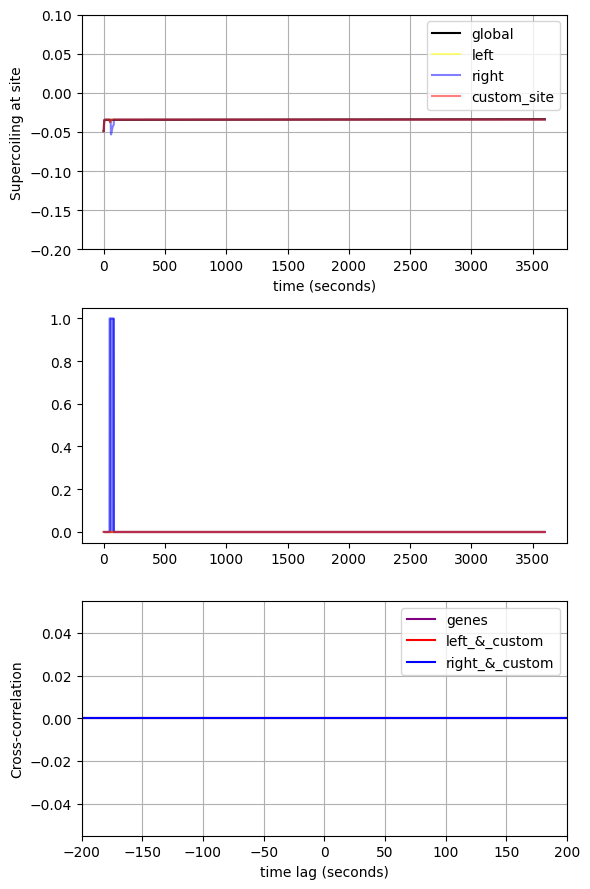

In [22]:
# This time, let's put all the plots in one figure
gene_names = ['left', 'right']
names = ['left', 'right', 'custom_site']
colors = {'left': 'yellow', 'right': 'blue', 'custom_site': 'red'}
fig, axs = plt.subplots(3, figsize=(6,9), tight_layout=True)

# Plot supercoiling
vs.plot_supercoiling_profiles(my_circuit, sites_df, colors=colors, axs=axs[0])#, only_global=True)

# Plot elongation signal
signals = an.build_elongation_signal_stages(enzymes_df, gene_names)
custom_enzyme_signal = an.build_signal_by_name(enzymes_df, 'custom_enzyme')
signals.append(custom_enzyme_signal)
time = np.arange(0, my_circuit.dt * len(signals[0]), my_circuit.dt)
y_0s = time * 0.0
for i, signal in enumerate(signals):
    name = names[i]
    axs[1].plot(time, signal, color=colors[name], label=name, alpha=0.5)
    axs[1].fill_between(time, signal, y_0s, color=colors[name], alpha=0.5)

# Plot cross correlations
crossmatrix, lag =  an.cross_correlation_hmatrix(signals, dt)
#my_label = f' lag={lag[np.argmax(crossmatrix[0, 1, :])]:.2f}s'
axs[2].plot(lag, crossmatrix[0, 1, :], color='purple', label='genes')
axs[2].plot(lag, crossmatrix[0, 2, :], color='red', label='left_&_custom')
axs[2].plot(lag, crossmatrix[1, 2, :], color='blue', label='right_&_custom')
axs[2].set_ylabel('Cross-correlation')
axs[2].set_xlabel('time lag (seconds)')
axs[2].set_xlim(-200, 200)
axs[2].legend(loc='best')
axs[2].grid(True)

#vs.plot_cross_correlation_with_site(my_circuit, sites_df, ref_name='left', axs=axs[2])

# And let's calculate the production rate:
for gene_name in gene_names:
    mask = environment_df['name'] == gene_name
    transcripts = environment_df[mask]['concentration'].iloc[-1]
    print(gene_name + ' gene production rate: ' + str(transcripts/(frames*dt)) +' transcript/seconds')